# Coursera Course Dataset Analysis

This analysis explores a Coursera dataset to uncover insights into course popularity, ratings, certificate types, and difficulty levels. Key objectives include understanding trends in student enrollment, identifying high-performing organizations, and analyzing the relationship between course features and student engagement.

Through data cleaning, exploratory data analysis (EDA), and visualization, the analysis aims to:

 - Highlight the most popular courses and organizations.
 - Examine the distribution of course difficulty, ratings, and certificate offerings.
 - Reveal correlations between enrollment, ratings, and course attributes.

The insights provide actionable recommendations for optimizing course design, improving student engagement, and aligning offerings with learner preferences.

In [110]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

%matplotlib inline
print('Setup Complete')

Setup Complete


In [ ]:
courses = pd.read_csv("Coursera_data.csv", index_col=[0])
courses[:3]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k


In [ ]:
# Remove 'course_' prefix from all column names
courses.columns = courses.columns.str.replace("course_", "", regex=False).str.lower()
# Make certificate_type lowercase
courses.certificate_type = courses.certificate_type.str.capitalize()
courses.head()

,title,organization,certificate_type,rating,difficulty,students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,Specialization,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,Course,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,Course,4.5,Mixed,130k
413,A Law Student's Toolkit,Yale University,Course,4.7,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,Course,4.8,Mixed,320k


In [113]:
courses.certificate_type.unique()

array(['Specialization', 'Course', 'Professional certificate'],
      dtype=object)

# Data cleaning

In [114]:
courses.shape

(891, 6)

In [115]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 134 to 163
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              891 non-null    object 
 1   organization       891 non-null    object 
 2   certificate_type   891 non-null    object 
 3   rating             891 non-null    float64
 4   difficulty         891 non-null    object 
 5   students_enrolled  891 non-null    object 
dtypes: float64(1), object(5)
memory usage: 48.7+ KB


In [116]:
courses.isnull().sum()

title                0
organization         0
certificate_type     0
rating               0
difficulty           0
students_enrolled    0
dtype: int64

In [117]:
courses.duplicated().any()

False

Checking duplicates in title

In [118]:
map = courses.duplicated("title", keep=False)
courses[map]

,title,organization,certificate_type,rating,difficulty,students_enrolled
756,Developing Your Musicianship,Berklee College of Music,Course,4.8,Mixed,41k
205,Developing Your Musicianship,Berklee College of Music,Specialization,4.8,Beginner,54k
181,Machine Learning,University of Washington,Specialization,4.6,Intermediate,290k
6,Machine Learning,Stanford University,Course,4.9,Mixed,3.2m
241,Marketing Digital,Universidade de São Paulo,Course,4.8,Beginner,81k
325,Marketing Digital,Universidad Austral,Specialization,4.7,Beginner,39k


No duplicates or Null values

In [119]:
# removing any possible excess spaces
courses = courses.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
# Suffix multipliers
suffix_multipliers = {"k": 1_000, "m": 1_000_000}


# Convert to numeric
def convert_to_num(value):
    return int(float(value[:-1]) * suffix_multipliers[value[-1]])


# Apply conversion
courses["students_enrolled"] = courses["students_enrolled"].apply(convert_to_num)
courses.head()

,title,organization,certificate_type,rating,difficulty,students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,Specialization,4.7,Beginner,5300
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,Course,4.7,Intermediate,17000
874,A Crash Course in Data Science,Johns Hopkins University,Course,4.5,Mixed,130000
413,A Law Student's Toolkit,Yale University,Course,4.7,Mixed,91000
635,A Life of Happiness and Fulfillment,Indian School of Business,Course,4.8,Mixed,320000


Outliers

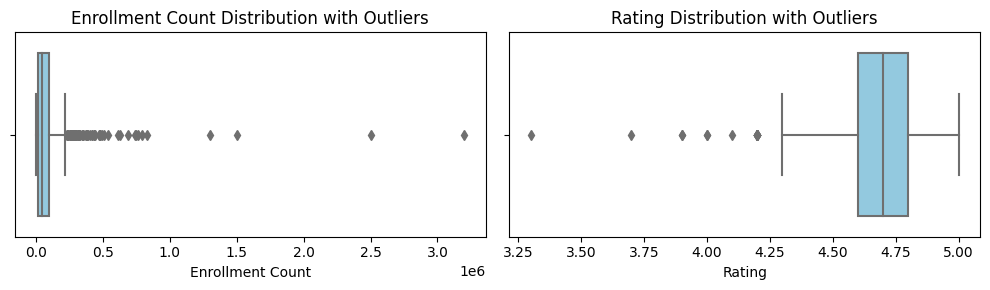

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot Enrollment Count Distribution with Outliers
sns.boxplot(x=courses.students_enrolled, color="skyblue", ax=axes[0])
axes[0].set_title("Enrollment Count Distribution with Outliers")
axes[0].set_xlabel("Enrollment Count")

# Plot Rating Distribution with Outliers
sns.boxplot(x=courses.rating, color="skyblue", ax=axes[1])
axes[1].set_title("Rating Distribution with Outliers")
axes[1].set_xlabel("Rating")

plt.tight_layout()

- Very few outliers, no data issue.

Removing outliers for some general analysis in future

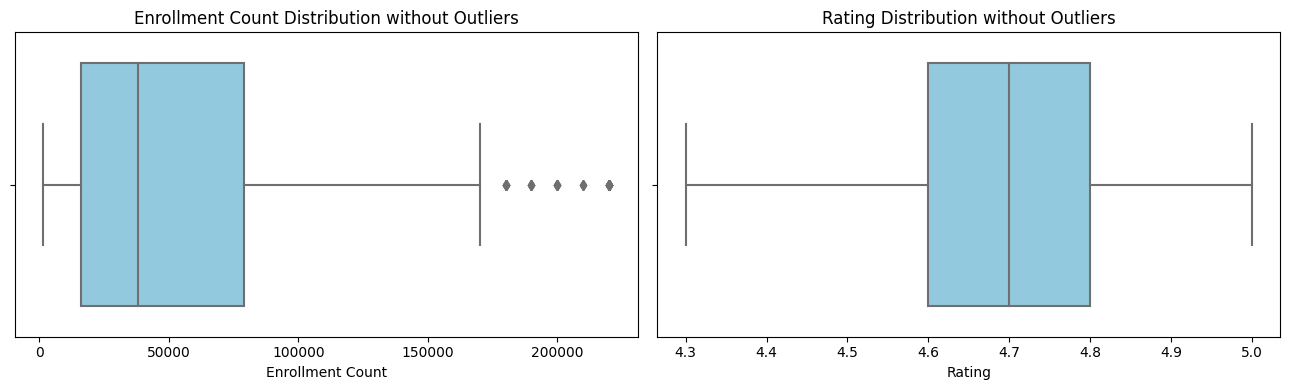

In [ ]:
# Calculating IQR bounds
def filter_iqr(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (column >= q1 - 1.5 * iqr) & (column <= q3 + 1.5 * iqr)


# Filtering out outliers
cleaned_courses_iqr = courses[
    filter_iqr(courses["students_enrolled"]) & filter_iqr(courses["rating"])
]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(13, 4))


# Plot Enrollment Count Distribution without Outliers
sns.boxplot(x=cleaned_courses_iqr.students_enrolled, color="skyblue", ax=axes[0])
axes[0].set_title("Enrollment Count Distribution without Outliers")
axes[0].set_xlabel("Enrollment Count")

# Plot Rating Distribution without Outliers
sns.boxplot(x=cleaned_courses_iqr.rating, color="skyblue", ax=axes[1])
axes[1].set_title("Rating Distribution without Outliers")
axes[1].set_xlabel("Rating")

# Display the plots
plt.tight_layout()

# EDA

### General Overview

In [123]:
courses.describe(include="all")

,title,organization,certificate_type,rating,difficulty,students_enrolled
count,891,891,891,891.000000,891,8.910000e+02
unique,888,154,3,NaN,4,NaN
top,Developing Your Musicianship,University of Pennsylvania,Course,NaN,Beginner,NaN
freq,2,59,582,NaN,487,NaN
mean,NaN,NaN,NaN,4.677329,NaN,9.055208e+04
std,NaN,NaN,NaN,0.162225,NaN,1.819365e+05
min,NaN,NaN,NaN,3.300000,NaN,1.500000e+03
25%,NaN,NaN,NaN,4.600000,NaN,1.750000e+04
50%,NaN,NaN,NaN,4.700000,NaN,4.200000e+04
75%,NaN,NaN,NaN,4.800000,NaN,9.950000e+04


Categorical fields

In [124]:
list(courses.select_dtypes(include="object").columns)

['title', 'organization', 'certificate_type', 'difficulty']

Numeric fields

In [125]:
list(courses.select_dtypes(exclude="object").columns)

['rating', 'students_enrolled']

Number of organizations

In [126]:
courses.organization.value_counts().size

154

Text(0, 0.5, 'Difficulty Level')

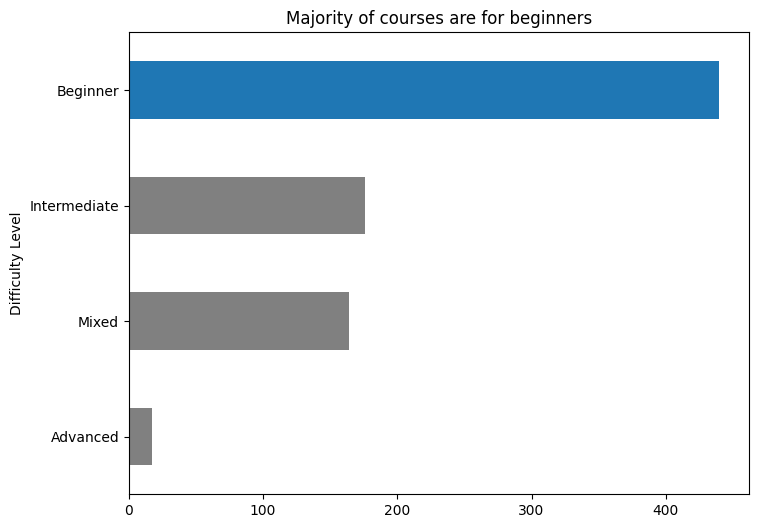

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = cleaned_courses_iqr.groupby("difficulty").size().sort_values().plot(kind="barh")
for i in range(len(ax.patches)):
    if i != 3:
        ax.patches[i].set_facecolor("grey")
plt.title("Majority of courses are for beginners")
plt.ylabel("Difficulty Level")

### Rating

Text(0.5, 0, 'Rating')

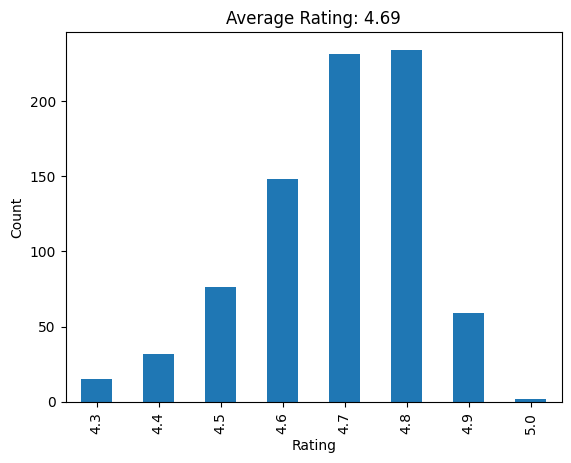

In [128]:
rating_counts = cleaned_courses_iqr["rating"].value_counts()
rating_counts.sort_index().plot(kind="bar")
plt.title(f"Average Rating: {cleaned_courses_iqr['rating'].mean():.2f}")
plt.ylabel("Count")
plt.xlabel("Rating")

- Most courses have high rating.

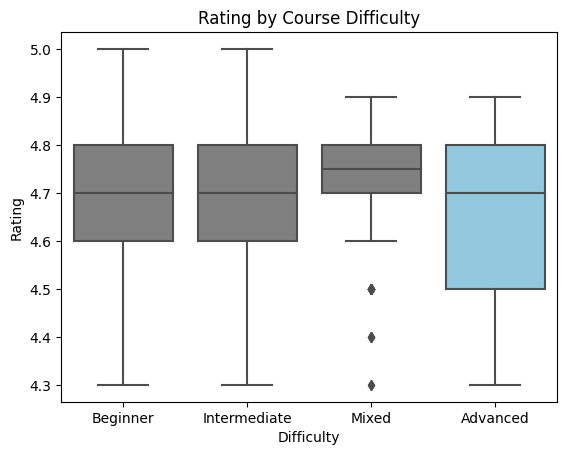

In [ ]:
palette = ["grey", "grey", "grey", "skyblue"]  # adjust colors

sns.boxplot(x="difficulty", y="rating", data=cleaned_courses_iqr, palette=palette)
plt.title("Rating by Course Difficulty")
plt.xlabel("Difficulty")
plt.ylabel("Rating")
plt.show()

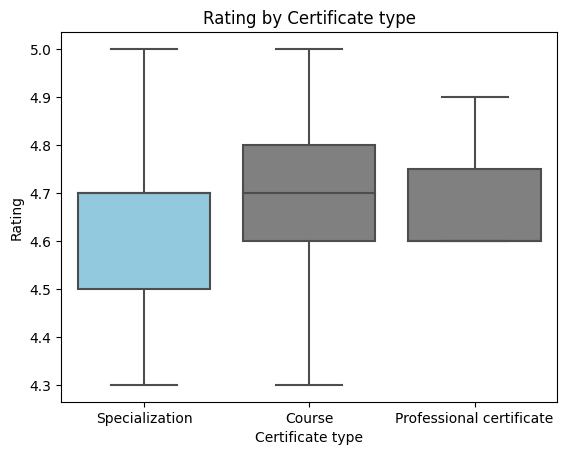

In [130]:
palette = ["skyblue", "grey", "grey"]
sns.boxplot(
    x="certificate_type",
    y="rating",
    data=cleaned_courses_iqr,
    palette=palette,
)
plt.title("Rating by Certificate type")
plt.xlabel("Certificate type")
plt.ylabel("Rating")
plt.show()

### Enrolled count

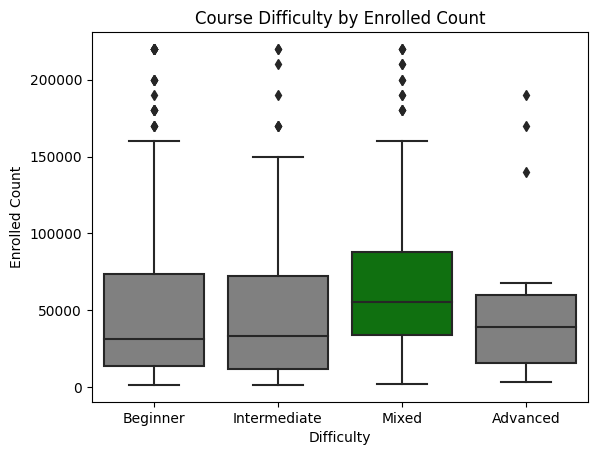

In [131]:
palette = [
    "grey",
    "grey",
    "green",
    "grey",
]
sns.boxplot(
    x="difficulty",
    y="students_enrolled",
    data=cleaned_courses_iqr,
    palette=palette,
)
plt.title("Course Difficulty by Enrolled Count")
plt.xlabel("Difficulty")
plt.ylabel("Enrolled Count")
plt.show()

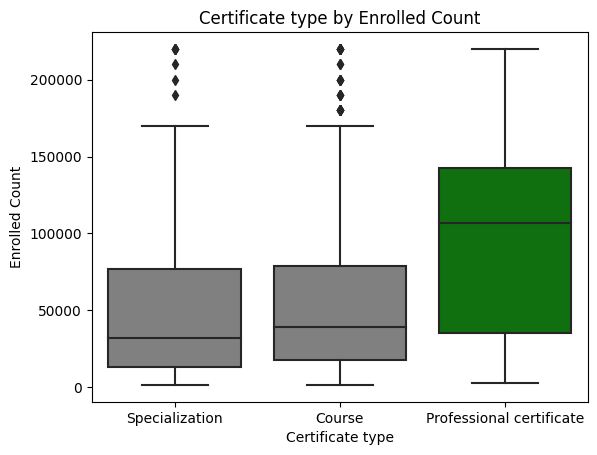

In [ ]:
palette = ["grey", "grey", "green"]
sns.boxplot(
    x="certificate_type",
    y="students_enrolled",
    data=cleaned_courses_iqr,
    palette=palette,
)
plt.title("Certificate type by Enrolled Count")
plt.xlabel("Certificate type")
plt.ylabel("Enrolled Count")
plt.show()  # pie chart

- The most popular type is the Professional Certificate

### Top 20 courses

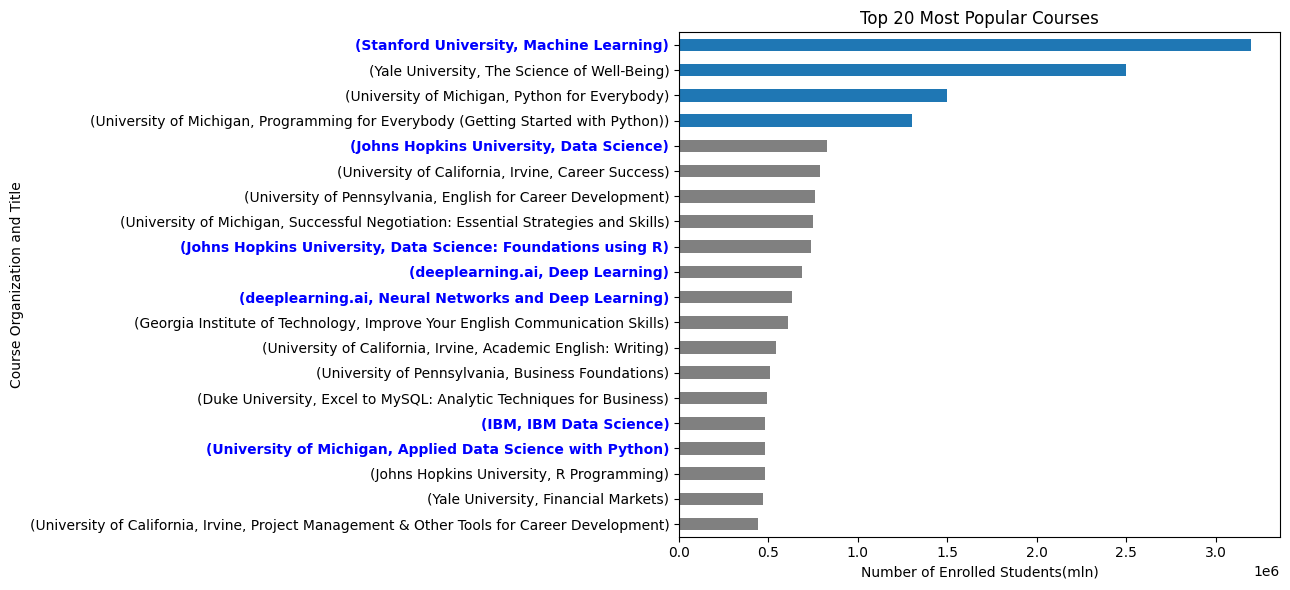

In [133]:
top_20_courses = (
    courses.groupby(["organization", "title"])
    .students_enrolled.sum()
    .sort_values(ascending=False)[:20]
)

# Reverse the order for horizontal bar chart
top_20_courses = top_20_courses.iloc[::-1]

# Plot the bar chart
ax = top_20_courses.plot(kind="barh", figsize=(13, 6))
plt.ylabel("Course Organization and Title")
plt.xlabel("Number of Enrolled Students(mln)")
plt.title("Top 20 Most Popular Courses")

# Highlight specific labels
highlight_keywords = ["Machine Learning", "Data Science", "Deep Learning"]
for label in ax.get_yticklabels():
    for keyword in highlight_keywords:
        if keyword in label.get_text():
            label.set_color("blue")
            label.set_fontweight("bold")

for i in range(len(ax.patches) - 4):
    ax.patches[i].set_facecolor("grey")

plt.tight_layout()
plt.show()

All **Data Science** related courses are marked <span style="color: blue; font-weight: bold;">blue</span>.

- A lot of Data Science courses.
- There are 4 leading courses, and 3 of them are related to Programming

### Top 20 organizations

In [ ]:
# Top 20 organizations by courses count
top_org = (
    courses["organization"].value_counts().sort_values(ascending=False).head(20).index
)
top_org_courses = courses[courses.organization.isin(top_org)]

# Data for plot 1
courses_count_by_difficulty = top_org_courses.pivot_table(
    index="organization",
    columns="difficulty",
    aggfunc="size",
    fill_value=0,
).reindex(columns=["Mixed", "Beginner", "Intermediate", "Advanced"])

courses_count_by_difficulty["total"] = courses_count_by_difficulty.sum(axis=1)
courses_count_by_difficulty = courses_count_by_difficulty.sort_values(
    by=["total", "Mixed"], ascending=True
)  # Ordering by total

# Top 20 organizations by enrolled students count
top_org_by_enrolled = (
    courses.groupby("organization")
    .students_enrolled.sum()
    .sort_values(ascending=False)[:20]
    .index
)
top_enrolled_courses = courses[courses.organization.isin(top_org_by_enrolled)]

# Data for plot 2
courses_by_enrolled = top_enrolled_courses.pivot_table(
    index="organization",
    columns="difficulty",
    values="students_enrolled",
    aggfunc="sum",
    fill_value=0,
).reindex(  # Columns order
    columns=[
        "Mixed",
        "Beginner",
        "Intermediate",
        "Advanced",
    ]
)

courses_by_enrolled["total"] = courses_by_enrolled.sum(axis=1)  # Finding total
courses_by_enrolled = courses_by_enrolled.sort_values(  # Ordering by total
    by=["total", "Mixed"], ascending=True
)

Portion of Top 20 Organizations in Overall

In [135]:
top_org_perc_enrolled = (
    top_enrolled_courses.students_enrolled.sum()
    / courses.groupby("organization").students_enrolled.sum().sum()
)
top_org_perc_courses = top_enrolled_courses.size / courses.size

print(
    f"""From Enrolled Overall: {top_org_perc_enrolled:.2f}%\nFrom Courses Count Overall: {top_org_perc_courses:.2f}%"""
)

From Enrolled Overall: 0.69%
From Courses Count Overall: 0.47%


In [136]:
colors = {
    "Mixed": "#1f77b4",  # Dark Blue
    "Beginner": "#aec7e8",  # Light Blue
    "Intermediate": "#98df8a",  # Light Green
    "Advanced": "#d62728",  # Dark Red
}


fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        "Top 20 Organizations by Number of Courses",
        "Top 20 Organizations by Popularity",
    ),
    horizontal_spacing=0.25,  # Avoiding overlap
)

# Adding plot 1
for difficulty in colors.keys():
    fig.add_trace(
        go.Bar(
            y=courses_count_by_difficulty.index,
            x=courses_count_by_difficulty[difficulty],
            name=difficulty,
            orientation="h",
            marker_color=colors[difficulty],
            legendgroup=difficulty,  # Grouping both labels
        ),
        col=1,
        row=1,
    )

# Adding plot 2
for difficulty in colors.keys():
    fig.add_trace(
        go.Bar(
            y=courses_by_enrolled.index,
            x=courses_by_enrolled[difficulty],
            name=difficulty,
            orientation="h",
            marker_color=colors[difficulty],
            legendgroup=difficulty,
        ),
        col=2,
        row=1,
    )

# Update layout for both subplots
fig.update_layout(
    title_text=f"Top 20 Organizations: Courses and Popularity (Portion from Overall: {top_org_perc_enrolled:.2f})",
    barmode="stack",
    height=550,
    width=1400,
    xaxis=dict(title="Number of Courses"),
    xaxis2=dict(title="Number of Students Enrolled (mln)"),
    xaxis_title="Number of Courses",
    xaxis2_title="Number of Students Enrolled(mln)",
    legend=dict(title="Difficulty", orientation="h", yanchor="middle", y=-0.2),
)


fig.show()

- _University of Pennsylvania_ has the most courses, but _University of Michigan_ is the most popular organization.
- The most popular difficulty level is **mixed**. Although the most number of courses are in **beginner** level.
- Very few enrolled for _advanced_.

Is there a correlation between course rating and enrolled number?

In [ ]:
courses.corr(method="spearman")

,rating,students_enrolled
rating,1.000000,0.026831
students_enrolled,0.026831,1.000000


 - Surprisingly no correlation between course rating and enrolled number

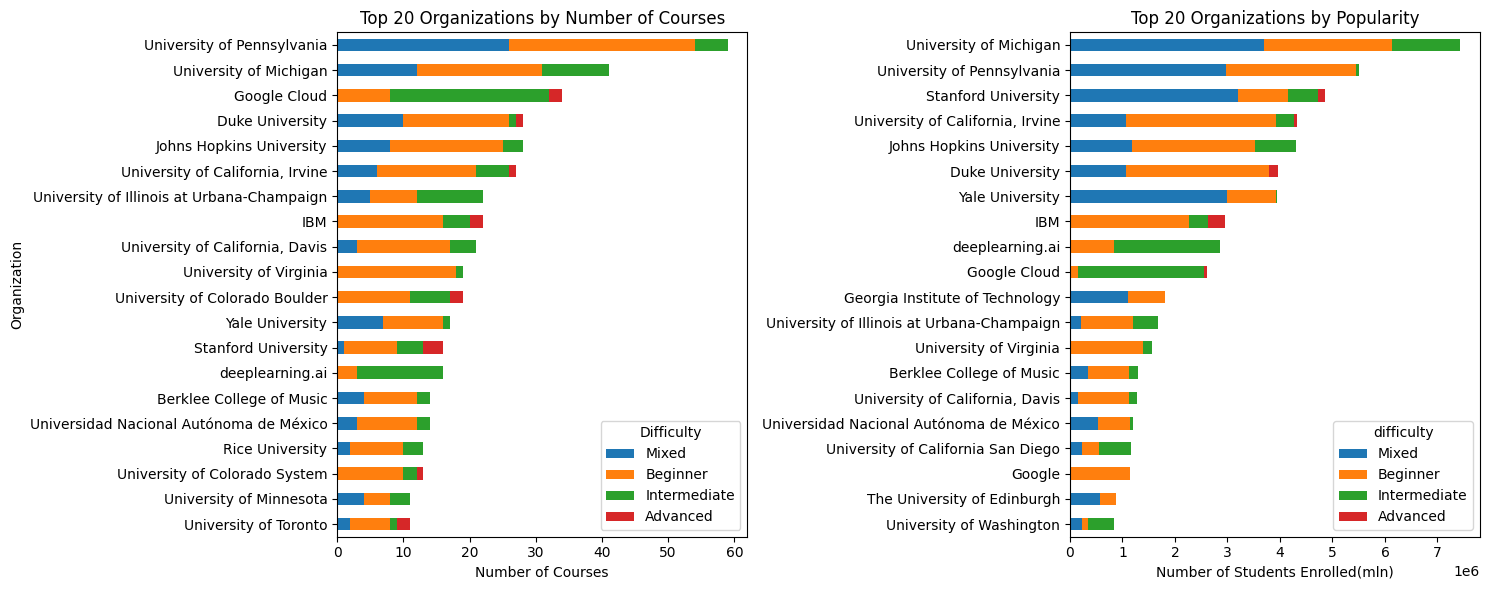

In [138]:
# Same plot with matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

courses_count_by_difficulty.loc[:, courses_count_by_difficulty.columns != "total"].plot(
    kind="barh", stacked=True, ax=axes[0]
)
axes[0].set_title("Top 20 Organizations by Number of Courses")
axes[0].set_ylabel("Organization")
axes[0].set_xlabel("Number of Courses")
axes[0].legend(title="Difficulty", loc="lower right")

# Plot 2: Top organizations by enrolled count


courses_by_enrolled.loc[:, courses_by_enrolled.columns != "total"].plot(
    kind="barh",
    stacked=True,
    ax=axes[1],
)
axes[1].set_title("Top 20 Organizations by Popularity")
axes[1].set_xlabel("Number of Students Enrolled(mln)")
axes[1].set_ylabel("")

fig.tight_layout()

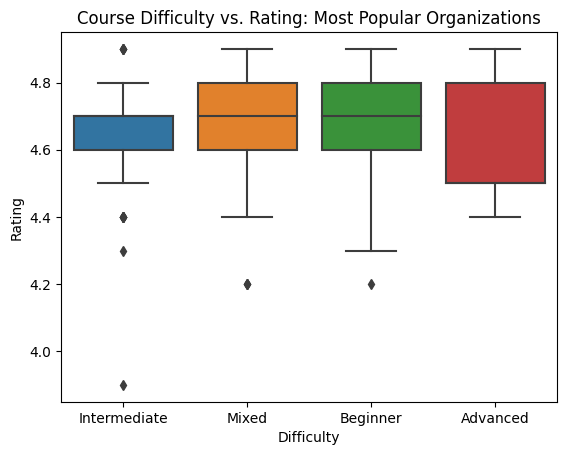

difficulty
Advanced        4.61
Beginner        4.69
Intermediate    4.65
Mixed           4.71
Name: rating, dtype: float64

In [ ]:
# add suplot
sns.boxplot(x="difficulty", y="rating", data=top_enrolled_courses)
plt.title("Course Difficulty vs. Rating: Most Popular Organizations")
plt.xlabel("Difficulty")
plt.ylabel("Rating")
plt.show()
top_enrolled_courses.groupby("difficulty").rating.mean().round(2)

- Not much difference

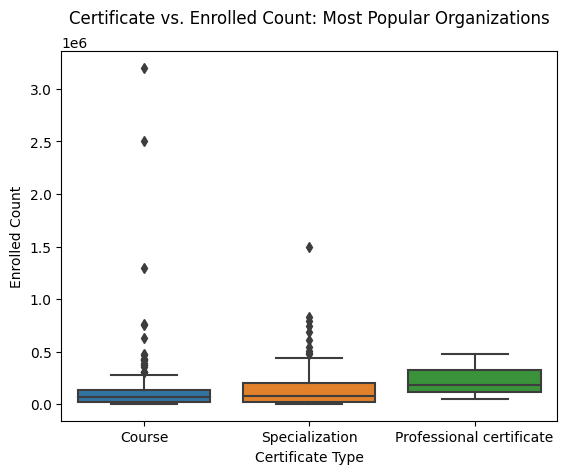

certificate_type
Course                      35163300
Professional certificate     1757000
Specialization              18694900
Name: students_enrolled, dtype: int64

In [ ]:
sns.boxplot(x="certificate_type", y="students_enrolled", data=top_enrolled_courses)
plt.title("Certificate vs. Enrolled Count: Most Popular Organizations", pad=20)
plt.xlabel("Certificate Type")
plt.ylabel("Enrolled Count")
plt.show()
top_enrolled_courses.groupby("certificate_type").students_enrolled.sum()

- The average number of enrolled is higher for _Professional Certificate_, but in overall count the _ is leading.

Which organizations offer the most courses for beginners?

In [ ]:
beginner_courses = (
    courses.groupby(["organization", "difficulty"]).size().reset_index(name="count")
)
beginner_courses = beginner_courses[beginner_courses["difficulty"] == "Beginner"]
most_beginner_courses_org = beginner_courses.loc[beginner_courses["count"].idxmax()]
most_beginner_courses_org.name = "Organizations with the most courses for beginners"
pd.DataFrame(most_beginner_courses_org)

,Organizations with the most courses for beginners
organization,University of Pennsylvania
difficulty,Beginner
count,28


Are certain organizations focusing more on advanced-level courses?

In [ ]:
counts = (
    courses.groupby(["organization", "difficulty"]).size().reset_index(name="count")
)
pivot = counts.pivot_table(
    index="organization",
    columns="difficulty",
    values="count",
    aggfunc="sum",
    fill_value=0,
)
pivot["advanced_vs_other"] = (pivot["Advanced"] / pivot.sum(axis=1)).round(2)
pivot_sorted = pivot.sort_values(by="advanced_vs_other", ascending=False)
pivot_sorted[:5]

difficulty,Advanced,Beginner,Intermediate,Mixed,advanced_vs_other
organization,,,,,
Autodesk,2,0,2,0,0.50
Erasmus University Rotterdam,1,3,0,1,0.20
Stanford University,3,8,4,1,0.19
University of Toronto,2,6,1,2,0.18
National Research University Higher School of Economics,1,5,1,0,0.14


Which organization has the highest ratio of course/enrolled?

In [ ]:
organization_data = (
    courses.groupby("organization")
    .agg(
        total_courses=("title", "count"),
        total_enrolled=("students_enrolled", "sum"),
    )
    .reset_index()
)

organization_data["enrolled_per_course"] = (
    organization_data["total_enrolled"] / organization_data["total_courses"]
)  # ratio


organization_data = organization_data.sort_values(
    by="enrolled_per_course", ascending=False
)

organization_data[["organization", "enrolled_per_course", "total_courses"]].head(20)

,organization,enrolled_per_course,total_courses
85,Stanford University,303375.000000,16
148,Yale University,232470.588235,17
58,McMaster University,230000.000000,1
33,Google - Spectrum Sharing,210000.000000,1
52,Ludwig-Maximilians-Universität München (LMU),192500.000000,2
151,École Polytechnique,190000.000000,1
135,University of Michigan,181407.317073,41
30,Georgia Institute of Technology,181300.000000,10
150,deeplearning.ai,178962.500000,16
142,University of Washington,167400.000000,5


In [144]:
fig = px.bar(
    organization_data[:20],
    x="enrolled_per_course",
    y="organization",
    orientation="h",
    title="Top 20 Organizations by Student Enrolled per Course",
    labels={
        "enrolled_per_course": "Students Enrolled Per Course",
        "organization": "Organization",
    },
)
fig.update_layout(
    width=1000,
    height=600,
    yaxis={"categoryorder": "total ascending"},
)

### Recommendations for Optimization  

1. **Focus on Popular Certification Types**  
   - **Observation**: Professional Certificates attract higher average enrollments.  
   - **Recommendation**: Coursera should prioritize creating and marketing Professional Certificates, particularly in trending domains like data science and programming.

2. **Expand Mixed-Difficulty Courses**  
   - **Observation**: Mixed-difficulty courses are the most popular among learners.  
   - **Recommendation**: Develop more courses with mixed difficulty to cater to a broader audience, appealing to both beginners and advanced learners.

3. **Enhance Advanced-Level Course Engagement**  
   - **Observation**: Enrollment for advanced-level courses is minimal.  
   - **Recommendation**: Consider offering additional support like guided learning paths, prerequisite bundles, or targeted marketing to encourage enrollment in advanced courses.

4. **Leverage Top Organizations’ Popularity**  
   - **Observation**: Organizations like the University of Michigan are leading in popularity.  
   - **Recommendation**: Collaborate more with these popular institutions to develop exclusive content or promote their existing courses.

5. **Boost Ratings for Specialization Certificates**  
   - **Observation**: Specialization certificates have lower ratings compared to other certification types.  
   - **Recommendation**: Improve the quality of specialization courses by incorporating engaging content, providing timely feedback, and ensuring clear course objectives.

6. **Target Data Science and Programming Enthusiasts**  
   - **Observation**: Data science and programming dominate the top 20 most popular courses.  
   - **Recommendation**: Invest in creating advanced and niche courses within these fields to attract professionals seeking in-depth knowledge.

7. **Incorporate Learner Feedback Mechanisms**  
   - **Observation**: No correlation was found between ratings and enrollment, indicating potential gaps in understanding learner preferences.  
   - **Recommendation**: Add post-completion surveys to gather insights about course satisfaction, engagement, and areas for improvement.


# Conclusion  

This analysis of the Coursera course dataset uncovered valuable insights into course trends, learner preferences, and areas for improvement. 
- Most courses cater to **beginners**, with high ratings predominantly between 4.7 and 4.8. 
- However, **mixed-difficulty** courses emerged as the **most popular**, while **advanced-level** courses saw **minimal enrollment**. 
- **Professional Certificates** were found to attract the **highest average enrollments**, while **specialization certificates** struggled with **lower ratings**. 
- Universities like the University of Michigan and the University of Pennsylvania played a significant role in course offerings and popularity.

To optimize outcomes, Coursera can focus on popular certification types, expand mixed-difficulty courses, and develop strategies to enhance engagement with advanced-level content. By leveraging learner feedback, collaborating with leading institutions, and targeting key demographics, Coursera can further strengthen its offerings and better align with learner needs. With these recommendations, Coursera has an opportunity to enhance both learner satisfaction and overall platform success.


### Suggestions for Improvement

- Additional Features: Include factors such as course price, reviews, or instructor experience for deeper insights. Bias as to the course created time
- Segmentation: Segment courses based on ratings or enrollment into low, medium, and high to find patterns.
- Text Analysis: Analyze title for trends in keywords indicating popular topics.